# **Analysis - Property click prediction**

----------------------------------------

### **Imports and Data Reading**

In [104]:
# Imports
# -------

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline
import re, json, ast
pd.set_option('display.max_columns', 100)

In [90]:

# Reading Data
property = pd.read_csv('G:\My Drive\Study\Stratascratch - Datasets\Dataset 1 - Property Click Prediction\property_data_set.csv')
photos = pd.read_csv('G:\My Drive\Study\Stratascratch - Datasets\Dataset 1 - Property Click Prediction\property_photos.tsv', delimiter='\t')
interations = pd.read_csv('G:\My Drive\Study\Stratascratch - Datasets\Dataset 1 - Property Click Prediction\property_interactions.csv')

In [91]:
# Function for Checking NULL Counts and NULL Percentages
# ======================================================
def check_null(df):
    null_val = pd.DataFrame()
    
    Null_Count = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), 
                              columns=['Null_Count'])
    
    Null_Percentage = pd.DataFrame(round((df.isnull().sum()/len(df))*100, 2).sort_values(ascending=False),
                                   columns=['Null_Percentage'])
    
    return pd.concat([Null_Count, Null_Percentage], axis = 1)
# ---------------------------------------------------------------------------------------------------------------------

### **Inital look at Property dataset**

In [92]:
print("Shape of Data: ", property.shape)
print("Unique Entries: ",property.property_id.nunique())
display(property.head())


Shape of Data:  (28888, 21)
Unique Entries:  28888


,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
0,ff808081469fd6e20146a5af948000ea,BHK2,09-03-2017 14:36,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP
1,ff8080814702d3d10147068359d200cd,BHK2,07-03-2017 12:02,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP
2,ff808081470c645401470fb03f5800a6,BHK2,10-03-2017 13:43,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP
3,ff808081470c6454014715eaa5960281,BHK3,09-03-2017 22:16,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP
4,ff808081474aa867014771a0298f0aa6,BHK1,15-03-2017 18:29,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF


In [93]:
# Checking for null values
check_null(property)

,Null_Count,Null_Percentage
pin_code,325,1.13
building_type,79,0.27
total_floor,43,0.15
lift,0,0.00
deposit,0,0.00
rent,0,0.00
swimming_pool,0,0.00
property_size,0,0.00
property_age,0,0.00
parking,0,0.00


 ### **Initial look at interaction dataset**
 

In [94]:
# Looking at Interactions
#
interations.head()

,property_id,request_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15


In [95]:
# Creating a click count for each unique property_id for the "Interactions".
# 
interaction_count = interations['property_id'].value_counts().reset_index()
interaction_count.columns = ['property_id', 'times_clicked']
print(interaction_count.shape)
display(interaction_count.head())


(22779, 2)


,property_id,times_clicked
0,ff80818159e061800159e4614bf4368d,193
1,ff8081815ae03cc6015aeb9caaf065ee,183
2,ff80818159c49a360159c600065a0c66,168
3,ff8081815a8d7af5015a8d85892d05ef,165
4,ff80818156b651790156b6cb4b360940,145


In [96]:
# Checking for Null values
display(check_null(interations))
display(check_null(interaction_count))

,Null_Count,Null_Percentage
property_id,0,0.0
request_date,0,0.0


,Null_Count,Null_Percentage
property_id,0,0.0
times_clicked,0,0.0


### **Initial look at property_photos dataset**
 

In [97]:
print("Shape of Data: ", photos.shape)
print("Unique Entries: ",photos.property_id.nunique())
display(photos.head())

Shape of Data:  (28888, 2)
Unique Entries:  28888


,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


This dataset will need some preprocessing to extract the number of photos per property.

In [98]:
# Checking for Null values
photos.isna().sum()

property_id        0
photo_urls     11022
dtype: int64

In [99]:
def format_json(x):
    if pd.isna(x):
        return []
    else:
        # Removing \
        x1 = str(x).replace("\\","")

        # Adding '"' before 'title'
        x2 = re.sub(r'{title', '{"title',x1)

        x3 = re.sub(r']"', ']', x2)

        try:
            x4 = json.loads(x3)
        except json.JSONDecodeError:
            x4 = []

    return x4
photos['processed_urls'] = photos['photo_urls'].apply(format_json)
photos.head(2)


,property_id,photo_urls,processed_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006...","[{'title': 'Balcony', 'name': 'IMG_20131006_12..."
1,ff8080814702d3d10147068359d200cd,NaN,[]


In [100]:
def count_photos(x):
    return len(x)

photos['number_of_photos'] = photos['processed_urls'].apply(count_photos)
photos.drop(['photo_urls','processed_urls'], axis=1, inplace=True)
photos.head(2)

,property_id,number_of_photos
0,ff808081469fd6e20146a5af948000ea,7
1,ff8080814702d3d10147068359d200cd,0


### **Merging the Datasets for primary analysis**

In [115]:
property_merged = property.merge(interaction_count, on='property_id').merge(photos, on='property_id')
print(property_merged.shape)
display(property_merged.head())

# Saving the data as ".csv"
property_merged.to_csv('G:\My Drive\Study\Stratascratch - Datasets\Dataset 1 - Property Click Prediction\propert_merged_1.csv')

(22779, 23)


,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,times_clicked,number_of_photos
0,ff808081469fd6e20146a5af948000ea,BHK2,09-03-2017 14:36,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,4,7
1,ff8080814702d3d10147068359d200cd,BHK2,07-03-2017 12:02,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,12,0
2,ff808081470c645401470fb03f5800a6,BHK2,10-03-2017 13:43,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,27,12
3,ff808081470c6454014715eaa5960281,BHK3,09-03-2017 22:16,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP,13,9
4,ff808081474aa867014771a0298f0aa6,BHK1,15-03-2017 18:29,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF,68,7


In [102]:
# Checking for Nulls
check_null(property_merged)

,Null_Count,Null_Percentage
pin_code,223,0.98
building_type,51,0.22
total_floor,28,0.12
property_id,0,0.00
locality,0,0.00
times_clicked,0,0.00
deposit,0,0.00
rent,0,0.00
swimming_pool,0,0.00
property_size,0,0.00


### **Basic Analysis**

In [103]:
display(property_merged.head())

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,times_clicked,number_of_photos
0,ff808081469fd6e20146a5af948000ea,BHK2,09-03-2017 14:36,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,4,7
1,ff8080814702d3d10147068359d200cd,BHK2,07-03-2017 12:02,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,12,0
2,ff808081470c645401470fb03f5800a6,BHK2,10-03-2017 13:43,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,27,12
3,ff808081470c6454014715eaa5960281,BHK3,09-03-2017 22:16,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,ANYONE,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP,13,9
4,ff808081474aa867014771a0298f0aa6,BHK1,15-03-2017 18:29,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,ANYONE,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF,68,7


#### **Univariaate Analysis**

#### **Bivariaate Analysis**

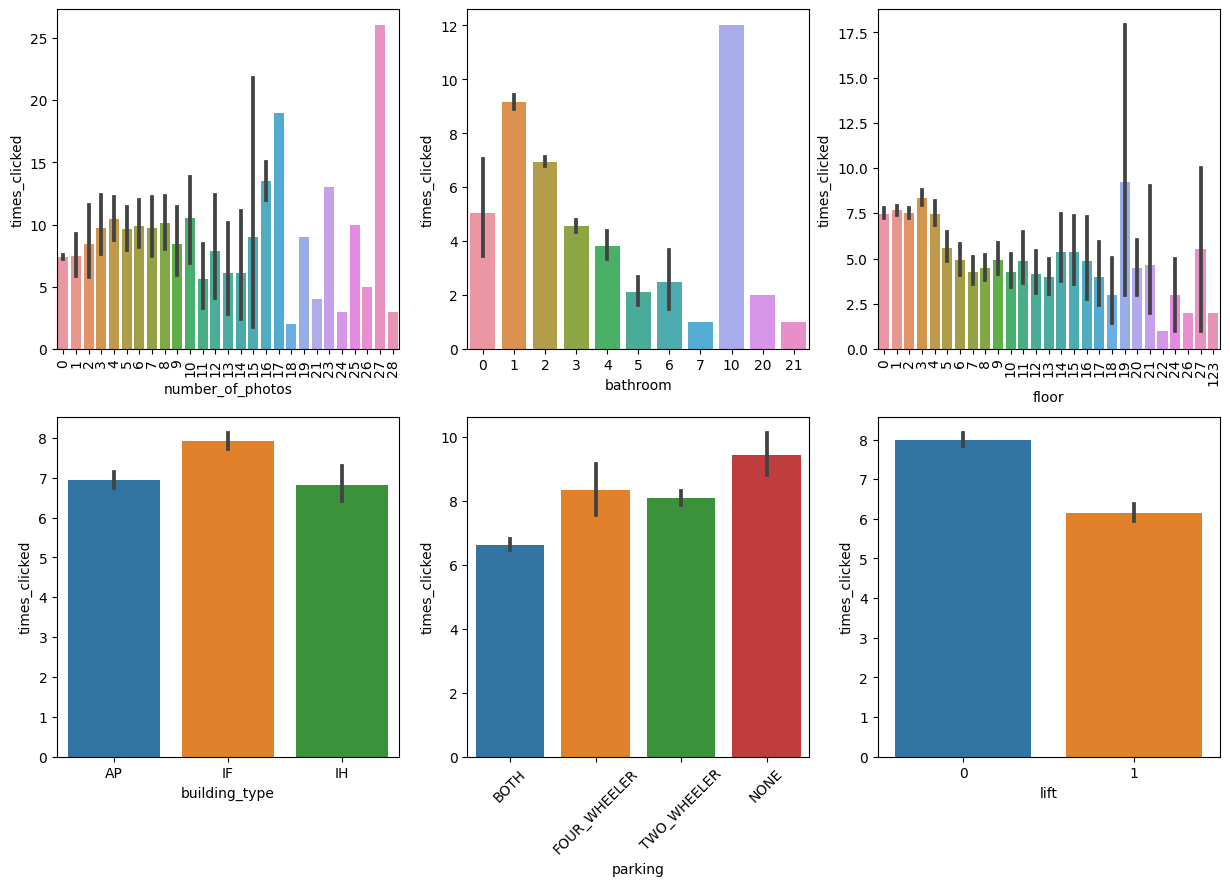

In [114]:

plt.figure(figsize=(15,15))

plt.subplot(3,3,1)
sns.barplot(x='number_of_photos', y='times_clicked', data=property_merged)
plt.xticks(rotation=90)

plt.subplot(3,3,2)
sns.barplot(x='bathroom', y='times_clicked', data=property_merged)

plt.subplot(3,3,3)
sns.barplot(x='floor', y='times_clicked', data=property_merged)
plt.xticks(rotation=90)

plt.subplot(3,3,4)
sns.barplot(x='building_type', y='times_clicked', data=property_merged)

plt.subplot(3,3,5)
sns.barplot(x='parking', y='times_clicked', data=property_merged)
plt.xticks(rotation=45)

plt.subplot(3,3,6)
sns.barplot(x='lift', y='times_clicked', data=property_merged)


plt.show()